# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Analysis
In this notoebook, statistical analysis is performed ot establish whether race has a significant impact on the rate of callbacks for resumes.

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
sum(data[data.race=='b'].call)

157.0

In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


## What test is appropriate for this problem? Does CLT apply?

<p> This sample has a Bernoulli distribution as there are only two outcomes for the 'call' variable. If similar samples were taken out of the overall population, the results would theoretically be binomially distributed.

As CLT is applicable in distributions even when they are binomial, as long as the sample size n is greater than 5 and n(1-p) is also greater than 5, CLT is applicable to this problem.

## What are the null and alternate hypotheses?

<p> The null hypothesis is that the call back rate for both white and black job applicants is the same.

The alternate hypthosis is that the call back rate for white and black job applicants is different.

In [5]:
# first, examine how many callbacks there were for applicants with black-sounding and white-sounding names

total_b = len(data[data.race == 'b'])
total_w = len(data[data.race == 'w'])
total_sample = total_b+total_w
call_b = int(data[data.race == 'b'].call.sum())
call_w = int(data[data.race == 'w'].call.sum())
total_calls = call_b+call_w
callrate_b = round(call_b/total_b, 3)
callrate_w = round(call_w/total_w, 3)

print('Callbacks for "black" names: ', call_b, ' / ', total_b)
print('Callback Rate: ', callrate_b)

print('Callbacks for "white" names: ', call_w, ' / ', total_w)
print('Callback Rate: ', callrate_w)


Callbacks for "black" names:  157  /  2435
Callback Rate:  0.064
Callbacks for "white" names:  235  /  2435
Callback Rate:  0.097


<p> Half of the sample is comprised of job applicants with white-sounding names, and the other half is job applicants with black-sounding names. The number of callbacks for applicants with black-sounding names is lower than the callbacks for applicants with white-sounding names

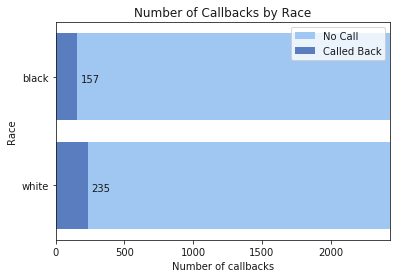

In [6]:
# create a stacked bar chart to depict relative ratios 

sns.set_color_codes("pastel")
sns.barplot(x=[total_b, total_w], y=['black', 'white'], label='No Call', data=data, color='b')

sns.set_color_codes("muted")
sns.barplot(x=[call_b, call_w], y=['black', 'white'], label='Called Back', data =data, color = 'b')
plt.text(call_w+25, 1.05, call_w)
plt.text(call_b+25, 0.05, call_b)

plt.legend(loc='best')
plt.autoscale(enable=True, axis='x', tight=True)

plt.xlabel('Number of callbacks')
plt.ylabel('Race')
plt.title('Number of Callbacks by Race')

plt.show()

## A two proportion z-test will be performed to test the null hypothesis that the callback rate is the same for both groups.

In [7]:
# write a function to perform a two-proportion z-test

def two_prop_ztest(success1, success2, sample1, sample2):
    """performs a two-proportion z-test for two samples"""
    prob = (success1 + success2) / (sample1 + sample2)
    z = ((success1 / sample1) - (success2 / sample2)) / np.sqrt(prob*(1-prob)*((1/sample1 + 1/sample2)))
    
    p_value = stats.norm.cdf(z) * 2
    return z, p_value

z_value, p_value = two_prop_ztest(call_b, call_w, total_b, total_w)

print('z_statistic: ', z_value)
print('p_value: ', p_value)

z_statistic:  -4.10841215243
p_value:  3.98388683759e-05


<p> The probability of getting a z-statistic of -4.11 is 3.98$^{-5}$, which is highly statistically significant. We can reject the null hypothesis that the callback rate is the same for black job applicants and white job applicants.

## Compute margin of error and confidence interval

In [8]:
def margin_of_error(sample_size, num_successes):
    """Determines the margin of error for a 95% confidence interval."""
    prob = num_successes / sample_size
    moe = 1.96 * np.sqrt(prob*(1-prob)* (1/total_b + 1/total_w))
    return moe

moe = margin_of_error(total_sample, total_calls)

prop_dif = (call_w / total_w) - (call_b / total_b)

confidence_interval = [prop_dif - moe, prop_dif + moe]

print('Margin of Error: ', moe)
print('Confidence Interval: ', confidence_interval)

Margin of Error:  0.0152819123109
Confidence Interval:  [0.016750941898551489, 0.047314766520339682]


## Write a story describing the statistical significance in the context of the original problem.

#### BACKGROUND
The original dataset contains data on 4,870 job applicants, half of which had black-sounding names while the other half had white-sounding names. In this notebook, the difference between the callback rate between job applicants with white-sounding names and applicants with black-sounding names is examined. 

It is suspected that racial discrimination exists in the US job market and that job applicants with white-sounding names are more likely to receive a callback than job applicants with black-sounding names. The dataset is examined to determine whether or not there is any statistical evidence to support this claim. 

The null hypothesis is that the callback rate is the same for job applicants with white-sounding and black-sounding names.

#### ANALYSIS

The callback rate for job applicants in the dataset with black-sounding names was about 6.4%, while applicants with white-sounding names received callbacks about 9.7%. Job applicants with white-sounding names were 50% more likely to receive a callback.

A two-proportion z-test is performed, resulting in a z-statistic of -4.11 and a p-value of 3.98$^{-5}$. This means it is highly unlikely that this sample came from a population where the callback rate was the same for both applicant pools. The null hypothesis can therefore be rejected.

The margin of error is 0.015, and the 95% confidence interval would include a difference in callback rates between 0.0168 and 0.0473. 

#### CONCLUSION

The null hypothesis can be rejected. It is highly unlikely that there is no difference between the callback rates for white job applicants and black job applicants.

## Does the analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend the analysis?

This analysis does not prove that race/name is the most important factor in callback success, just that the two are correlated. 

There were many other pieces of information collected about the job applicants that may have had an effect on the callback rate as well, such as the applicant's education level, number of previous jobs, and whether or not they have computer skills or other special skills. 

To account for the affects of these other variables, the data should be standardized for education level and other effects.


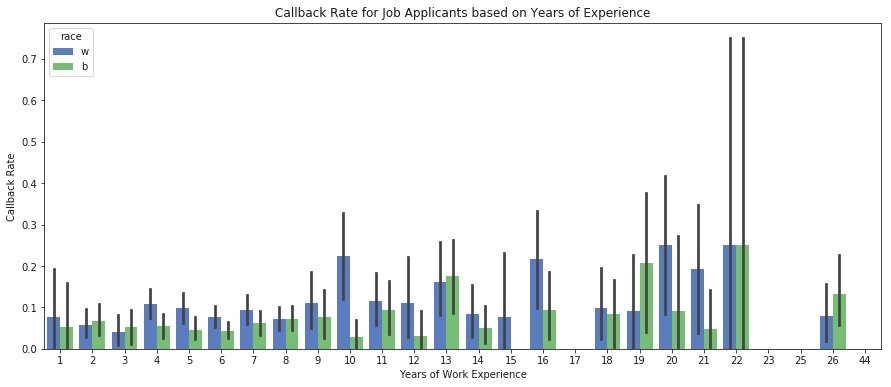

In [9]:
plt.figure(figsize=(15,6))
sns.barplot(x="yearsexp", y='call', hue="race", data=data, palette='muted')

plt.xlabel('Years of Work Experience')
plt.ylabel('Callback Rate')
plt.title('Callback Rate for Job Applicants based on Years of Experience')
plt.show()